# Finding a linear transformation between two vectors with a constrained spectrum.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_infrequent_true_constraint.ipynb)


:::{note}
This example highlights the use of the flags `contributes_to_primal_update` and
`contributes_to_dual_update` in the `ConstraintState` class. These flags are used to
specify whether a constraint violation contributes to the primal or dual update. By
default, both flags are set to True. However, in this example, we update the primal
parameters based on a surrogate constraint since the true constraint is expensive to
compute, and difficult to differentiate. The true constraint is only computed every
few iterations, and the multipliers are updated based on the true constraint.
:::

Consider the problem of finding the matrix $X$ that transforms a vector $y$
so as to minimize the mean squared error between $Xy$ and another vector $z$.
The problem has a constraint on the geometric mean of the singular values of $X$.
Formally,

$$
\min_{X}  \,\, \Vert Xy - z \Vert_2^2  \,\, \text{ such that } \,\, \prod_{i=1}^r \sigma_i(X) = c^r
$$

where $X \in \mathbb{R}^{m \times n}$, $y \in \mathbb{R}^m$,
$z \in \mathbb{R}^n$, $r = \min\{m, n\}$, $\sigma_i(X)$ denotes the
$i$-th singular value of $X$, and $c$ is a constant.

We calculate the geometric mean of the singular values of $X$ by first computing
the singular value decomposition of $X$. Note that the SVD decomposition is
relatively expensive. However, the *arithmetic* mean of the squared singular values of
$X$ can be computed cheaply as it corresponds to the trace of $X X^T$.

Therefore, we can use the arithmetic mean as a surrogate for the true constraint on the
geometric mean of the singular values of X. While this choice of surrogate is not
guaranteed to produce the same solution as the true constraint, the tutorial illustrates
it is a good practical heuristic.

This example illustrates the ability to update the primal and dual variables at
different frequencies. Here, we make use of the cheap surrogate constraint to update the
primal variables at every iteration, while the multipliers are updated using the \_true\_
constraint which is only observed sporadically. Note how the multiplier value remains
constant in-between measurements of the true constraint.

In [1]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

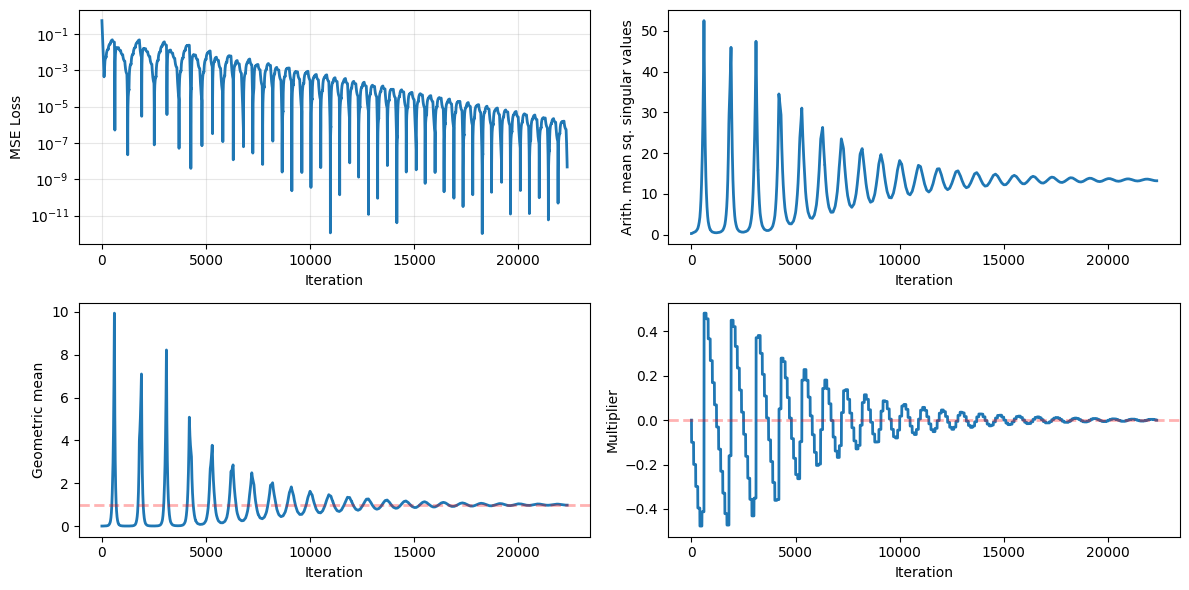

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

import cooper

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_vectors(dim_y: int, dim_z: int, seed: int = 0):
    """Create y and z such that Xy = z is true for a well-conditioned matrix X."""
    torch.manual_seed(seed=seed)

    # Create a random linear system with all singular values equal to 1.
    U, _, V = torch.linalg.svd(torch.randn(dim_z, dim_y))
    S = torch.eye(dim_z, dim_y)
    X_true = U @ S @ V.T

    y = torch.randn(dim_y, 1)
    y = y / torch.linalg.norm(y)

    z = X_true @ y
    z = z / torch.linalg.norm(z)

    y, z = y.to(DEVICE), z.to(DEVICE)

    return y, z


class MinNormWithSingularValueConstraints(cooper.ConstrainedMinimizationProblem):
    """Find a matrix X to minimize the error of a linear system, under a constraint on
    the geometric mean of the singular values of X.
    """

    def __init__(self, y: torch.Tensor, z: torch.Tensor, constraint_level: float = 1.0):
        super().__init__()

        self.y, self.z = y, z
        self.r = min(y.shape[0], z.shape[0])
        self.constraint_level = constraint_level

        # Creating a constraint with a single equality constraint
        constraint_type = cooper.ConstraintType.EQUALITY
        multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)
        self.sv_constraint = cooper.Constraint(
            constraint_type=constraint_type, formulation_type=cooper.LagrangianFormulation, multiplier=multiplier
        )

    def loss_fn(self, X: torch.Tensor) -> torch.Tensor:
        """Compute the MSE loss function for a given X."""
        return torch.linalg.norm(X @ self.y - self.z).pow(2) / 2

    def compute_arithmetic_mean(self, X: torch.Tensor) -> torch.Tensor:
        """Compute the arithmetic mean of the singular values of X."""
        # We use the *arithmetic* mean of the squared singular values of X as a
        # surrogate for the true constraint given by the geometric mean of the singular
        # values of X.
        # Since the surrogate is only used to compute gradients, there is no need to set
        # a constraint level offset.
        # This is equivalent to computing the trace of X * X^T (and dividing by r)
        return torch.einsum("ij,ij->", X, X) / self.r

    def compute_surrogate_cmp_state(self, X: torch.Tensor) -> cooper.CMPState:
        """Compute the CMPState for a given X."""
        # Compute the objective
        objective = self.loss_fn(X)

        # We include the constraint level offset, but note that it is irrelevant since
        # the surrogate constraint is used only to compute gradients.
        surrogate_violation = self.compute_arithmetic_mean(X) - self.constraint_level

        # `strict_violation` is not measured, so only X is updated (and not the
        # multipliers). We must specify `contributes_to_dual_update=False` to avoid
        # updating the multipliers based on the surrogate constraint.
        constraint_state = cooper.ConstraintState(
            violation=surrogate_violation, contributes_to_primal_update=True, contributes_to_dual_update=False
        )

        return cooper.CMPState(loss=objective, observed_constraints={self.sv_constraint: constraint_state})

    @staticmethod
    @torch.no_grad()
    def compute_geometric_mean(X: torch.Tensor) -> torch.Tensor:
        return torch.linalg.svdvals(X).prod()

    def compute_true_cmp_state(self, X: torch.Tensor) -> cooper.CMPState:
        # Compute the objective
        objective = self.loss_fn(X)

        # Compute the non-differentiable constraint to update the multipliers.
        # This is only done sporadically since the SVD decomposition is expensive.
        # Geometric mean of singular values of X *equal* to `constraint_level`.
        true_violation = self.compute_geometric_mean(X) - self.constraint_level

        constraint_state = cooper.ConstraintState(
            violation=true_violation, contributes_to_primal_update=False, contributes_to_dual_update=True
        )

        return cooper.CMPState(loss=objective, observed_constraints={self.sv_constraint: constraint_state})

    def compute_cmp_state(self, X: torch.Tensor, true_or_surrogate: str = "true") -> cooper.CMPState:
        if true_or_surrogate == "true":
            return self.compute_true_cmp_state(X)
        if true_or_surrogate == "surrogate":
            return self.compute_surrogate_cmp_state(X)
        raise ValueError("Invalid value for `true_or_surrogate`.")


def run_experiment(dim_y, dim_z, constraint_level, max_iter, tolerance, freq_for_dual_update, primal_lr, dual_lr):
    y, z = create_vectors(dim_y=dim_y, dim_z=dim_z, seed=0)

    X = np.random.randn(dim_z, dim_y) / np.sqrt(dim_y * dim_z)

    # Creating X as a tensor from scratch for it to be a leaf tensor
    X = torch.tensor(X, requires_grad=True, device=DEVICE, dtype=torch.float32)

    cmp = MinNormWithSingularValueConstraints(y=y, z=z, constraint_level=constraint_level)
    primal_optimizer = torch.optim.SGD([X], lr=primal_lr)
    dual_optimizer = torch.optim.SGD(cmp.dual_parameters(), lr=dual_lr, maximize=True, foreach=False)
    cooper_optimizer = cooper.optim.AlternatingDualPrimalOptimizer(
        primal_optimizers=primal_optimizer, cmp=cmp, dual_optimizers=dual_optimizer
    )

    # Initial values of the loss, trace and geometric mean
    with torch.no_grad():
        state_history = {
            "loss": [cmp.loss_fn(X).item()],
            "arithmetic_mean": [cmp.compute_arithmetic_mean(X).item()],
            "geometric_mean": [cmp.compute_geometric_mean(X).item()],
            "multiplier_values": [cmp.sv_constraint.multiplier.weight.item()],
        }

    for it in range(max_iter):
        prev_X = X.clone().detach()

        true_or_surrogate = "true" if it % freq_for_dual_update == 0 else "surrogate"

        cooper_optimizer.roll({"X": X, "true_or_surrogate": true_or_surrogate})

        if prev_X.allclose(X, atol=tolerance):
            break

        with torch.no_grad():
            state_history["loss"].append(cmp.loss_fn(X).item())
            state_history["arithmetic_mean"].append(cmp.compute_arithmetic_mean(X).item())
            state_history["geometric_mean"].append(cmp.compute_geometric_mean(X).item())
            state_history["multiplier_values"].append(cmp.sv_constraint.multiplier.weight.item())

    return state_history


def plot_results(state_history, constraint_level):
    _, ax = plt.subplots(2, 2, figsize=(12, 6))

    ax[0, 0].plot(state_history["loss"])
    ax[0, 0].set_ylabel("MSE Loss")
    ax[0, 0].set_yscale("log")
    ax[0, 0].grid(True, which="both", alpha=0.3)

    ax[0, 1].plot(state_history["arithmetic_mean"])
    ax[0, 1].set_ylabel("Arith. mean sq. singular values")

    ax[1, 0].plot(state_history["geometric_mean"])
    ax[1, 0].set_ylabel("Geometric mean")
    # Horizontal line at desired `constraint_level`
    ax[1, 0].axhline(constraint_level, color="red", linestyle="--", alpha=0.3)

    ax[1, 1].plot(state_history["multiplier_values"])
    ax[1, 1].set_ylabel("Multiplier")
    ax[1, 1].axhline(0, color="red", linestyle="--", alpha=0.3)

    for ax_ in ax.flatten():
        ax_.set_xlabel("Iteration")
        for line in ax_.get_lines():
            line.set_linewidth(2)

    plt.tight_layout()

    plt.show()


dim_y, dim_z = 4, 4
constraint_level = 1.0 ** min(dim_y, dim_z)
primal_lr, dual_lr = 3e-2, 1e-1
freq_for_dual_update = 100
max_iter, tolerance = 50_000, 1e-6


state_history = run_experiment(
    dim_y=dim_y,
    dim_z=dim_z,
    constraint_level=constraint_level,
    max_iter=max_iter,
    tolerance=tolerance,
    freq_for_dual_update=freq_for_dual_update,
    primal_lr=primal_lr,
    dual_lr=dual_lr,
)
plot_results(state_history, constraint_level)